In [1]:
!pip install gmplot
!pip install pyproj
!pip install mplstereonet

In [2]:
# IMPORTANTE ATTENZIONE OCCORRE CONVERTIRE IL FILE DIINGRESSO DEI PUNTI
# IN COORDINATE PIANE METRICHE 

import pandas as pd
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import datetime

import mplstereonet
#from mpl_toolkits.basemap import pyproj
#from mpl_toolkits.basemap import Basemap
from pyproj import Proj, transform
 
# Import plotly package
import plotly
plotly.tools.set_credentials_file(username='davide.schenone', api_key='WBSgVI0FXgSIRecK2cHU')
import plotly.graph_objs as go

# Check ploltly version
plotly.__version__

# To communicate with Plotly's server, sign in with credentials file
import plotly.plotly as py
from pandas import ExcelWriter
from pandas import ExcelFile

# Create data with x and y random over [-2, 2], and z a Gaussian function of x and y.
#np.random.seed(12345)
#x = 2 * (np.random.random(500) - 0.5)
#y = 2 * (np.random.random(500) - 0.5)

#def f(x, y):
 #   return np.exp(-(x + y ** 2))

#z = f(x, y)

#imposto i dati
#importa il file originale
#df = pd.read_csv('Saorge_Taggia_erh_erz_prof.csv', sep='\t', names=['y', 'x','z','a','b'])

#importa il file convertito con convergo
df = pd.read_excel('terremoti_santo.xlsx', sheet_name='Foglio1')

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
df['z'] = df['Prof corr']  #creo il campo z profondità con valori negativi


df['Data'] = df['Data'].astype(str).str.zfill(6) #riempie la mancanza dello zero nei primi valori
df['Data'] =  pd.to_datetime(df['Data'],  format='%y%m%d')
#df['Ora'] =  pd.to_time(df['Ora'],  format='%H%M')
#creo una colonna con  la differenza in giorni tra la data e una posta abbastanza indietro nel passato
df['Deltatime'] = df['Data'] - datetime.date(1989,1,1)
df['Deltatime'] = df['Deltatime'].astype(datetime.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)

#converto le coordinate wgs 84 in UTM epsg 3003 Gauss-Boaga 
x1 = np.array(df['Longit.'])
y1 = np.array(df['Latitud.'])


inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3003')
x2,y2 = transform(inProj,outProj, x1, y1)

df['x'] = x2
df['y'] = y2

#con questo posso fare dei cluster temporali
#IMPOSTO I FILTRI

#df_filter = df.query('Erh<1 and Erz<4') #imposto i parametri di filtro sugli errori orizzontali e verticali


#df_filter = df.query('<Deltatime<') #imposto il filtro sulla data

#imposto i pesi per il calcolo del piano da utilizzare in caso di regressione lineare pesata

df['weight_calc'] = df['Nf']/24 - 0.25
def weight(df):
    if df['Nf'] <=6 :
        return 0
    
    elif  df['Nf'] > 6 and df['Nf']  < 30   :
        return df['weight_calc']
            
    elif  df['Nf'] >= 30 :
        return 1

df['weights'] =  df.apply(weight, axis=1) 
 

    
    
df_filter = df



## Procedo con il PRIMO  clustering attraverso DBSCAN (BASE TEMPORALE)

In [4]:

coords = df_filter.as_matrix(columns=['Deltatime'])

from sklearn.cluster import DBSCAN
import numpy as np

db = DBSCAN(eps=70, min_samples=10).fit(coords)
labels = db.labels_
from collections import Counter


df_filter = df_filter.assign(Classe = labels)

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88



In [5]:
Counter(labels)

Counter({-1: 61, 0: 62, 1: 19, 2: 25, 3: 42})

# INSERIRE CICLO FOR

In [6]:
#filtro la label di interesse
df_cluster = df_filter[df_filter['Classe'] == 0]



## Procedo con il SECONDO  clustering attraverso DBSCAN (BASE SPAZIALE)

In [7]:
df_filter_2 = df_cluster
coords_2 = df_cluster.as_matrix(columns=['x','y','z'])

from sklearn.cluster import DBSCAN
import numpy as np

db = DBSCAN(eps=3000, min_samples=5).fit(coords_2)
labels_2 = db.labels_
from collections import Counter


df_filter_2 = df_filter_2.assign(Classe_spaziale = labels_2)

In [8]:
Counter(labels_2)


Counter({-1: 6, 0: 50, 1: 6})

In [9]:
#filtro la label di interesse
df_cluster_2 = df_filter_2[df_filter_2['Classe_spaziale'] == 0]

## CREO UNA MAPPA 

In [10]:
#Creo una mappa dei punti su google maps

from gmplot import gmplot
gmap = gmplot.GoogleMapPlotter( 44.5514, 9.4335, 13)

# Scatter points
top_attraction_lats = df['Latitud.']
top_attraction_lons = df['Longit.']


filter_attraction_lats = df_filter['Latitud.']
filter_attraction_lons = df_filter['Longit.']

cluster_attraction_lats = df_cluster_2['Latitud.']# *******ATTENZIONE SONO DATI FILTRATI E CLUSTERIZZATI
cluster_attraction_lons = df_cluster_2['Longit.']



gmap.scatter(top_attraction_lats, top_attraction_lons, '#3B0B39', size=100, marker=False)

#gmap.scatter(filter_attraction_lats, filter_attraction_lons, '#f90707', size=40, marker=False)

gmap.scatter(cluster_attraction_lats, cluster_attraction_lons, '#1307f9', size=50, marker=False)

gmap.heatmap(cluster_attraction_lats, cluster_attraction_lons ) # crea una heatmap
# Draw
gmap.draw("my_map_time.html")

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:39: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:531: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:558: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


/home/nbuser/anaconda3_501/lib/python3.6/site-packag

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~davide.schenone/0 or inside your plot.ly account where it is named 'test1'


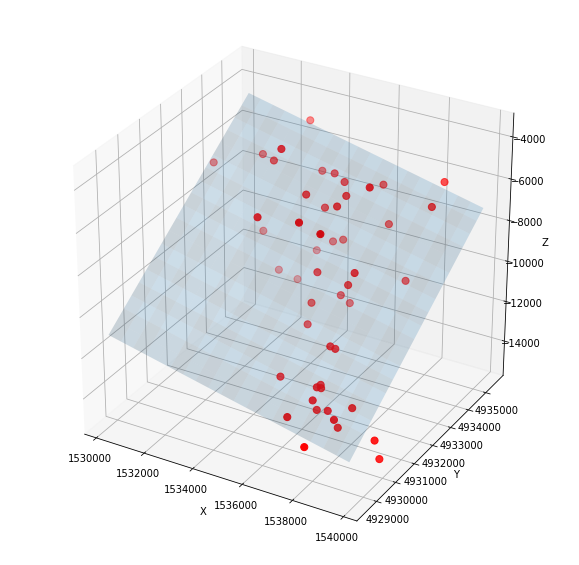

In [11]:
#importo il file depurato degli outlayer:
#df = pd.read_csv('taggia_saorge_ripulita_outlier.csv', sep=',', names=['x', 'y','z'])
    
x = df_cluster_2['x']  
    
y = df_cluster_2['y']   
    
z = df_cluster_2['z']

W = df_cluster_2['weights']


data =  df_cluster_2.as_matrix(columns=['x','y','z'])

# regular grid covering the domain of the data
mn = np.min(data, axis=0)
mx = np.max(data, axis=0)
X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
XX = X.flatten()
YY = Y.flatten()
    
# best-fit linear plane (1st-order)
# applico i pesi

A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
L = data[:,2]
AW = A * np.sqrt(W[:,np.newaxis]) # intermedi con pesi per  calcolo dei coefficienti
LW = L * np.sqrt(W)               # intermedi con pesi per  calcolo dei coefficienti

C,_,_,_ = scipy.linalg.lstsq(AW, LW)    # coefficients

# evaluate it on grid
Z = C[0]*X + C[1]*Y + C[2]
    
# or expressed using matrix/vector product
#Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

# plot points and fitted surface using Matplotlib
fig1 =  plt.figure(figsize=(10, 10))
ax = fig1.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
ax.axis('tight')

# plot points and fitted surface using Plotly
trace1 = go.Scatter3d(
    x=data[:,0],
    y=data[:,1],
    z=data[:,2],
    mode='markers',
    marker=dict(size=4, color='red', line=dict(color='black', width=0.5), opacity=0.85)
)

trace2 = go.Surface(z=Z, x=X, y=Y, colorscale='RdBu', opacity=0.6)

# Package the trace dictionary into a data object
data_test1 = go.Data([trace1, trace2])

# Dictionary of style options for all axes
axis = dict(
    showbackground=True, # show axis background
    backgroundcolor="rgb(204, 204, 204)", # set background color to grey
    gridcolor="rgb(255, 255, 255)",       # set grid line color
    zerolinecolor="rgb(255, 255, 255)",   # set zero grid line color
)

# Make a layout object
layout = go.Layout(
    title='1st-order (linear) plane', # set plot title
    scene=go.Scene(  # axes are part of a 'scene' in 3d plots
        xaxis=go.XAxis(axis), # set x-axis style
        yaxis=go.YAxis(axis), # set y-axis style
        zaxis=go.ZAxis(axis)),  # set z-axis style
)

# Make a figure object
fig = go.Figure(data=data_test1, layout=layout)

# Send to Plotly and show in notebook
py.iplot(fig, filename='test1')

In [12]:
print("%f x + %f y + %f = z" % (C[0], C[1], C[2]))

-0.273925 x + 0.917267 y + -4112612.143230 = z


In [13]:
#ricavo la direzione e l'immersione del piano attraverso l'equazione del piano e i coseni direttori

A=C[0]
B=C[1]
C_=-1
D=C[2]

#calcolo E
E=np.sqrt(A**2 + B**2 + 1)

#calcolo i coseni
cos_a = A/E

cos_b = B/E

cos_cp = C_/E  #gamma_p


cos_c = np.cos((np.pi/2) + np.arccos(C_/E))   #controllare se è corretto 

 

print(cos_a, cos_b, cos_c, cos_cp)


-0.19787340118658572 0.6625997185310941 -0.6915144755495959 -0.7223626029255442


dip_direction= 163.372698 ; dip= 43.750113
-0.19787340118658572 0.6625997185310941
##################################################
-16.62730216624595


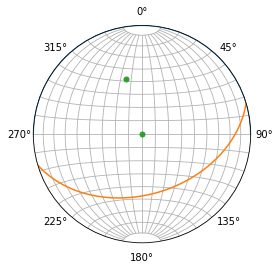

In [14]:
#calcolo la direzione teta del vettore, il coseni direttori danno la direzione del vettore occorrre aggiungere 90°
teta_primo = np.arctan(cos_a/cos_b)   #espresso in radianti
teta_deg = (teta_primo*180)/np.pi 

#calcolo della direzione della massima pendenza sul piano
#dip_direction = teta_deg 

#calcolo l'immersione dip angolo tra la verticale e il piano
dip_vert = np.arcsin(-1*cos_c)
dip_deg = (dip_vert*180)/np.pi

#calcolo l'immersione dip
dip = dip_deg
#occorre orientare correttamente il dip_direction
#cond_1 = dip_direction = teta_deg
#cond_2 = dip_direction = teta_deg + 180
#cond_3 = dip_direction =  teta_deg + 360
    
#def orientation(cos_a,cos_b):
    
if cos_a > 0 and cos_b > 0:                
    dip_direction = teta_deg
    if cos_cp <0:
        dip_direction =  dip_direction + 180
        
if  cos_a > 0 and cos_b < 0:
    dip_direction = teta_deg + 180
    if cos_cp <0:
        dip_direction =  dip_direction + 180
        
            
if  cos_a < 0 and cos_b < 0:
    dip_direction = teta_deg + 180
    if cos_cp <0:
        dip_direction =  dip_direction - 180
       
    
if  cos_a < 0 and cos_b > 0:
    dip_direction =  teta_deg + 360
    if cos_cp <0:
        dip_direction =  dip_direction - 180
    

    

    
         


#creo l'array per il plotaggio su stereogramma
plot_dip_direction = 0
plot_dip = 0
plot_dip_direction = np.append(plot_dip_direction, dip_direction)
plot_dip = np.append(plot_dip, dip)
print("dip_direction= %f ; dip= %f" % (dip_direction, dip))
print(cos_a, cos_b)
print('##################################################')
print(teta_deg)
output = "teta= %f ; dip= %f" % (dip_direction, dip)
file = open("giacitura_cluster_xx.txt","w")
file.write(output)
file.close()

daframe_cluster_xx = pd.DataFrame.to_csv(df_cluster_2)
file = open("daframe_cluster_xx.csv","w")
file.write(daframe_cluster_xx)
file.close()


strike = plot_dip_direction - 90 
dip =  plot_dip
fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')
ax.plane(strike, dip)
ax.pole(strike, dip ,markersize=5)
ax.grid()
plt.show()

In [15]:
#mostro le statistiche del database
df.describe()

,Ora,Sec,Latitud.,Longit.,Prof.,Mag,Nf,Gap,Dst,Rms,Erh,Erz,Prof corr,z,Deltatime,x,y,weight_calc,weights
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.0,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,2.090000e+02,2.090000e+02,209.000000,209.000000
mean,1113.976077,27.017703,44.559868,9.416046,8.811244,2.0,22.392344,133.052632,16.933014,0.206986,1.519139,1.510526,-8811.244019,-8811.244019,8244.588517,1.533072e+06,4.934165e+06,0.683014,0.614035
std,657.802186,16.317132,0.045876,0.086794,6.538911,0.0,10.563414,54.243061,12.186662,0.088105,1.241671,1.112380,6538.911444,6538.911444,2173.000850,6.903589e+03,5.078510e+03,0.440142,0.314105
min,22.000000,0.250000,44.366200,9.117800,1.040000,2.0,6.000000,74.000000,1.000000,0.030000,0.500000,0.200000,-59520.000000,-59520.000000,308.000000,1.509344e+06,4.912674e+06,0.000000,0.000000
25%,546.000000,12.010000,44.537700,9.402200,5.380000,2.0,14.000000,99.000000,12.000000,0.140000,0.900000,0.900000,-11220.000000,-11220.000000,8313.000000,1.531965e+06,4.931685e+06,0.333333,0.333333
50%,1140.000000,26.310000,44.558000,9.443700,6.180000,2.0,20.000000,110.000000,15.000000,0.210000,1.200000,1.300000,-6180.000000,-6180.000000,9044.000000,1.535275e+06,4.933971e+06,0.583333,0.583333
75%,1632.000000,41.770000,44.587000,9.467200,11.220000,2.0,30.000000,146.000000,18.000000,0.260000,1.600000,1.800000,-5380.000000,-5380.000000,9466.000000,1.537136e+06,4.937141e+06,1.000000,1.000000
max,2356.000000,59.120000,44.802500,9.636000,59.520000,2.0,74.000000,327.000000,98.000000,0.530000,11.300000,9.200000,-1040.000000,-1040.000000,10289.000000,1.550553e+06,4.961036e+06,2.833333,1.000000


In [16]:
#mostro le statistiche del database filtrao
df_cluster_2.describe()

,Ora,Sec,Latitud.,Longit.,Prof.,Mag,Nf,Gap,Dst,Rms,...,Erz,Prof corr,z,Deltatime,x,y,weight_calc,weights,Classe,Classe_spaziale
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.0,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.00000,50.00000,50.000000,5.000000e+01,5.000000e+01,50.000000,50.000000,50.0,50.0
mean,1025.900000,29.088200,44.542392,9.453192,9.412200,2.0,24.100000,120.360000,16.400000,0.176200,...,1.412000,-9412.20000,-9412.20000,8352.260000,1.536030e+06,4.932236e+06,0.754167,0.675833,0.0,0.0
std,548.069497,17.338082,0.016711,0.026179,3.154734,0.0,10.494411,35.330371,2.718043,0.070011,...,0.552043,3154.73424,3154.73424,82.643026,2.085470e+03,1.849747e+03,0.437267,0.331873,0.0,0.0
min,146.000000,1.310000,44.508700,9.380000,3.700000,2.0,8.000000,82.000000,10.000000,0.030000,...,0.500000,-14940.00000,-14940.00000,8197.000000,1.530208e+06,4.928505e+06,0.083333,0.083333,0.0,0.0
25%,553.750000,11.265000,44.526050,9.439125,6.075000,2.0,16.000000,98.000000,14.000000,0.130000,...,1.000000,-12330.00000,-12330.00000,8325.000000,1.534909e+06,4.930433e+06,0.416667,0.416667,0.0,0.0
50%,1031.500000,27.395000,44.544600,9.454000,9.540000,2.0,26.000000,101.000000,16.000000,0.180000,...,1.300000,-9540.00000,-9540.00000,8328.000000,1.536091e+06,4.932483e+06,0.833333,0.833333,0.0,0.0
75%,1527.000000,44.480000,44.557000,9.469650,12.330000,2.0,32.000000,125.750000,18.750000,0.220000,...,1.700000,-6075.00000,-6075.00000,8432.000000,1.537341e+06,4.933850e+06,1.083333,1.000000,0.0,0.0
max,1958.000000,58.080000,44.572000,9.500700,14.940000,2.0,51.000000,239.000000,23.000000,0.400000,...,3.300000,-3700.00000,-3700.00000,8524.000000,1.539817e+06,4.935508e+06,1.875000,1.000000,0.0,0.0


In [17]:
df_cluster_2

,Data,Ora,Sec,Latitud.,Longit.,Prof.,Mag,Nf,Gap,Dst,...,Erz,Prof corr,z,Deltatime,x,y,weight_calc,weights,Classe,Classe_spaziale
17,2011-06-12,250,23.02,44.5183,9.4722,12.46,2,51,98,14,...,1.3,-12460.0,-12460.0,8197,1.537555e+06,4.929568e+06,1.875000,1.000000,0,0
18,2011-06-12,257,31.96,44.5505,9.4540,6.04,2,38,99,17,...,1.4,-6040.0,-6040.0,8197,1.536089e+06,4.933137e+06,1.333333,1.000000,0,0
19,2011-06-12,424,9.91,44.5462,9.4385,6.00,2,32,95,18,...,1.8,-6000.0,-6000.0,8197,1.534860e+06,4.932652e+06,1.083333,1.000000,0,0
20,2011-06-12,430,50.63,44.5312,9.4695,11.27,2,32,99,15,...,1.7,-11270.0,-11270.0,8197,1.537332e+06,4.931000e+06,1.083333,1.000000,0,0
21,2011-06-12,1755,27.10,44.5312,9.4670,11.22,2,43,99,15,...,1.5,-11220.0,-11220.0,8197,1.537134e+06,4.930999e+06,1.541667,1.000000,0,0
25,2011-08-22,1958,22.31,44.5312,9.4513,5.73,2,16,103,16,...,1.3,-5730.0,-5730.0,8268,1.535886e+06,4.930992e+06,0.416667,0.416667,0,0
26,2011-08-24,340,1.60,44.5140,9.4643,13.08,2,34,96,13,...,0.5,-13080.0,-13080.0,8270,1.536930e+06,4.929087e+06,1.166667,1.000000,0,0
32,2011-10-06,933,7.53,44.5590,9.4878,6.44,2,10,161,18,...,1.6,-6440.0,-6440.0,8313,1.538768e+06,4.934097e+06,0.166667,0.166667,0,0
33,2011-10-06,1116,8.34,44.5268,9.4670,12.68,2,30,98,15,...,1.2,-12680.0,-12680.0,8313,1.537136e+06,4.930510e+06,1.000000,1.000000,0,0
34,2011-10-06,1124,1.31,44.5677,9.4853,6.04,2,10,161,19,...,2.2,-6040.0,-6040.0,8313,1.538564e+06,4.935062e+06,0.166667,0.166667,0,0


In [18]:
LW

17   -12460.000000
18    -6040.000000
19    -6000.000000
20   -11270.000000
21   -11220.000000
25    -3698.699096
26   -13080.000000
32    -2629.118991
33   -12680.000000
34    -2465.819674
37   -12330.000000
38    -8390.000000
39   -12330.000000
40    -6429.152355
41    -7050.000000
42   -12970.000000
43    -9430.000000
44    -8105.997779
45   -10443.243430
47    -9906.566004
48    -4567.300443
49    -6440.000000
50    -5548.094267
51    -4641.896164
52    -5477.225575
53    -9959.421837
54    -5820.000000
55    -6180.000000
56    -3822.058782
57   -11903.836916
58    -8204.269722
59    -5486.857024
60    -4312.806511
61    -9722.075396
62    -9855.369095
63    -5744.562647
64    -3085.476732
65    -8712.586681
66    -5101.934274
67    -6530.000000
69   -11270.000000
70    -7733.056748
71    -5676.048728
72    -5211.595645
73    -3731.389375
74    -5360.000000
75    -4582.575695
76    -2580.000000
77    -2825.921679
78    -6960.299024
Name: weights, dtype: float64

In [19]:
L

array([-12460.,  -6040.,  -6000., -11270., -11220.,  -5730., -13080.,
        -6440., -12680.,  -6040., -12330.,  -8390., -12330.,  -9960.,
       -14100., -12970.,  -9430.,  -9360., -11440., -14010.,  -5980.,
        -6440., -13590.,  -8040.,  -6000., -10910.,  -5820.,  -6180.,
       -13240., -13040., -12710., -13440., -14940., -10650., -11380.,
        -6000.,  -4780.,  -9100.,  -6680.,  -6530., -11270., -11980.,
       -10510.,  -9650.,  -9140.,  -5360.,  -6000.,  -5160.,  -3700.,
        -7110.])

In [20]:
L == LW

17     True
18     True
19     True
20     True
21     True
25    False
26     True
32    False
33     True
34    False
37     True
38     True
39     True
40    False
41    False
42     True
43     True
44    False
45    False
47    False
48    False
49     True
50    False
51    False
52    False
53    False
54     True
55     True
56    False
57    False
58    False
59    False
60    False
61    False
62    False
63    False
64    False
65    False
66    False
67     True
69     True
70    False
71    False
72    False
73    False
74     True
75    False
76    False
77    False
78    False
Name: weights, dtype: bool

In [21]:
df_cluster_2['weights']

17    1.000000
18    1.000000
19    1.000000
20    1.000000
21    1.000000
25    0.416667
26    1.000000
32    0.166667
33    1.000000
34    0.166667
37    1.000000
38    1.000000
39    1.000000
40    0.416667
41    0.250000
42    1.000000
43    1.000000
44    0.750000
45    0.833333
47    0.500000
48    0.583333
49    1.000000
50    0.166667
51    0.333333
52    0.833333
53    0.833333
54    1.000000
55    1.000000
56    0.083333
57    0.833333
58    0.416667
59    0.166667
60    0.083333
61    0.833333
62    0.750000
63    0.916667
64    0.416667
65    0.916667
66    0.583333
67    1.000000
69    1.000000
70    0.416667
71    0.291667
72    0.291667
73    0.166667
74    1.000000
75    0.583333
76    0.250000
77    0.583333
78    0.958333
Name: weights, dtype: float64